In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = False


print('Total images for train: {0}'.format(len(os.listdir('train_v2/'))))
print('Total images for test: {0}'.format(len(os.listdir('test_v2/'))))

Total images for train: 192556
Total images for test: 15606


In [2]:
df = pd.read_csv('train_ship_segmentations_v2.csv')
df.iloc[6000:6010:1]

,ImageId,EncodedPixels
6000,06915a6ca.jpg,168986 2 169752 5 170521 4 171289 5 172058 5 1...
6001,06915a6ca.jpg,169054 1 169820 3 170587 5 171355 5 172124 4 1...
6002,06915a6ca.jpg,215862 4 216630 4 217398 4 218167 4 218935 4 2...
6003,06915a6ca.jpg,134542 1 135308 4 136075 5 136844 5 137612 6 1...
6004,06915a6ca.jpg,173607 5 174375 5 175143 5 175911 5 176679 6 1...
6005,06918eb4b.jpg,NaN
6006,06919997a.jpg,333872 2 334640 5 335407 9 336175 12 336943 14...
6007,06919997a.jpg,95171 2 95939 5 96706 8 97474 11 98241 14 9900...
6008,06919997a.jpg,100558 2 101326 5 102093 9 102861 11 103628 15...
6009,06919997a.jpg,512188 3 512956 8 513724 13 514491 19 515259 2...


In [3]:
# Изображение с 2 кораблями
df[df['ImageId'] == '057836607.jpg']

,ImageId,EncodedPixels
5005,057836607.jpg,247616 2 248381 5 249146 9 249911 12 250676 15...
5006,057836607.jpg,283597 3 284361 7 285127 9 285895 10 286663 10...


In [5]:
"""
Напишем функцию RLE-кодирования - функция для сжатия данных,
заменяющий повторяющиеся символы (серии) на один символ и число его повторов
""" 

def rle_decode(mask_rle, shape=(768,768)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) \
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts,ends):
        img[lo:hi] = 1      
    img = img.reshape(shape).T
    return img


"""
Напишем функцию создающую единный массив масок для всех кораблей
""" 

def masks_as_image(in_mask_list):
    allMasks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            allMasks += rle_decode(mask)
    return np.expand_dims(allMasks, -1)

**Пример**

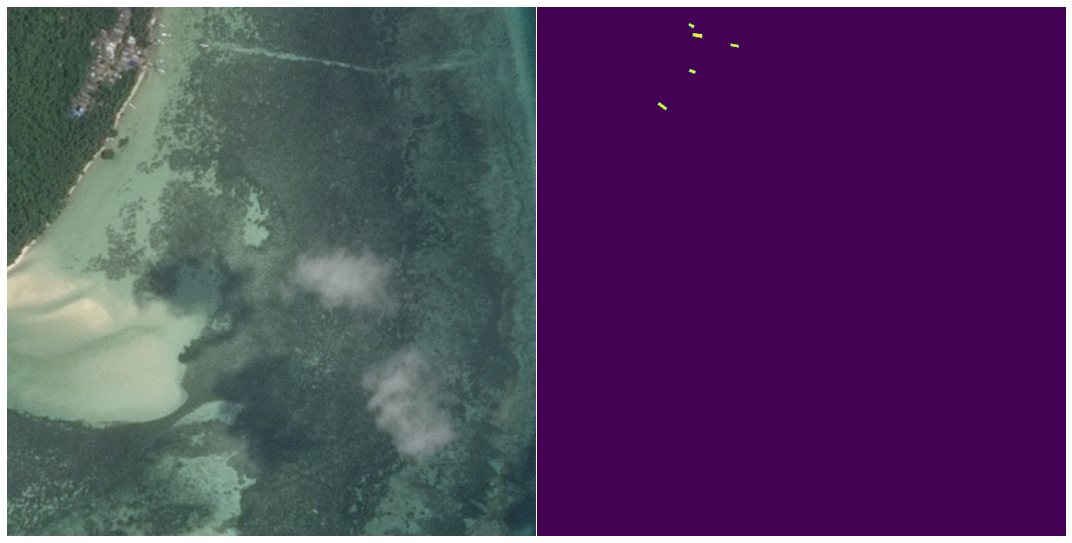

In [5]:
# Возьмем изображение, где больше 2 кораблей + подсветим их

ImageId = '06915a6ca.jpg'
img = cv2.imread('train_v2/{}'.format(ImageId))
img_masks = df.loc[df['ImageId'] == ImageId, 'EncodedPixels'].tolist()

allMasks = np.zeros((768, 768))
for mask in img_masks:
    allMasks += rle_decode(mask)
    
fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].imshow(img[...,[2,1,0]]) #rgb
axarr[1].imshow(allMasks, cmap='viridis')
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


masks = df.drop(df[df['EncodedPixels'].isnull()].\
                sample(70000,random_state=42).index)

# **Разделение на группы обучения и проверки**

In [6]:
from sklearn.model_selection import train_test_split

uniqueImgId = masks.groupby('ImageId').size().reset_index(name='Counts')

train_ids, valid_ids = train_test_split(uniqueImgId, test_size = 0.05, stratify = uniqueImgId['Counts'], random_state=42)

train_df = pd.merge(df, train_ids)
print(train_df.shape[0], 'training masks')
valid_df = pd.merge(df, valid_ids)
print(valid_df.shape[0], 'validation masks')


train_df['Counts'] = train_df.apply(lambda c_row: c_row['Counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
valid_df['Counts'] = valid_df.apply(lambda c_row: c_row['Counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)

train_df.head()
valid_df.head()

153636 training masks
8087 validation masks


,ImageId,EncodedPixels,Counts
0,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
1,0002756f7.jpg,248878 1 249645 4 250413 6 251180 9 251948 10 ...,2
2,001e3f475.jpg,NaN,0
3,001eda01f.jpg,368419 8 369187 8 369955 8 370723 8 371491 8 3...,1
4,002abd5df.jpg,NaN,0


# **Генератор данных для keras**

In [7]:
def masks_as_image(in_mask_list):
    allMasks = np.zeros((768, 768), dtype = np.float16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            allMasks += rle_decode(mask)
    return np.expand_dims(allMasks, -1)

IMG_SCALING = (1, 1)

def keras_generator(gen_df, batch_size=4):
    all_batches = list(gen_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join('train_v2', c_img_id)
            c_img = cv2.imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0],\
                              ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0],\
                                ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)\
                /255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

# **SegNet**

In [8]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import GlobalAveragePooling2D, UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers


inp = Input(shape=(768,768,3))


# Первый блок
conv_1_1 = Conv2D(32, (3,3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

# Второй блок
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

# Третий блок
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

# Четвертый блок
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

# Пятый блок
conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)

conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_4_2)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [9]:
# Декодирующие блоки

# Первый блок
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conv_up_1_1 = Conv2D(512, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(512, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)

# Второй блок
up_2 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_2_1 = Conv2D(256, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(256, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)

# Третий блок
up_3 = UpSampling2D(2, interpolation='bilinear')(pool_3)
conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)

# Четвёртый блок
up_4 = UpSampling2D(2, interpolation='bilinear')(pool_2)
conv_up_4_1 = Conv2D(64, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(64, (3, 3), padding='same')(conv_up_4_1)
conv_up_4_2 = Activation('relu')(conv_up_4_2)

# Пятый блок
up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conv_up_5_1 = Conv2D(32, (3, 3), padding='same')(up_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)

conv_up_5_2 = Conv2D(1, (3, 3), padding='same')(conv_up_5_1)
result = Activation('sigmoid')(conv_up_5_2)

In [10]:
segnet_model = Model(inputs=inp, outputs=result)
segnet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 768, 768, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 768, 768, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 768, 768, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 768, 768, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 384, 384, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 384, 384, 64)      18496 

In [11]:
best_w = keras.callbacks.ModelCheckpoint('best_segnet.w', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

last_w = keras.callbacks.ModelCheckpoint('last_segnet.w', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq=1)

callbacks = [best_w, last_w]

In [28]:
import keras.backend as K
from keras.losses import binary_crossentropy

def IoU(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3])\
    + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps)\
                  / (union + eps), axis=0)

def zero_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

def agg_loss(in_gt, in_pred):
    return -1e-2 * zero_IoU(in_gt, in_pred)
- IoU(in_gt, in_pred)  

adam = keras.optimizers.adam_v2.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)    
 
segnet_model.compile(optimizer=adam, loss=agg_loss, metrics=[IoU, zero_IoU, 'binary_accuracy'])

loss_history = segnet_model.fit(keras_generator(train_df), steps_per_epoch=100, epochs=5, validation_data=keras_generator(valid_df), validation_steps=50)

# **Unet**

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(768, 768, 3))


# Первый блок
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


# Второй блок
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


# Третий блок
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


# Четвёртый блок
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)


# Пятый блок
conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)

conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_5_2)


In [13]:
# Декодирующие блоки
# Первый блок
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conc_1 = Concatenate()([conv_5_2, up_1])

conv_up_1_1 = Conv2D(512, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(512, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


# Второй блок
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_4_2, up_2])

conv_up_2_1 = Conv2D(256, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(256, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


# Третий блок
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_3_2, up_3])

conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)


# Четвёртый блок
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_2_2, up_4])

conv_up_4_1 = Conv2D(64, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(64, (3, 3), padding='same')(conv_up_4_1)
conv_up_4_2 = Activation('relu')(conv_up_4_2)


# Пятый блок
up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_5 = Concatenate()([conv_1_2, up_5])
conv_up_5_1 = Conv2D(32, (3, 3), padding='same')(conc_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)

conv_up_5_2 = Conv2D(1, (3, 3), padding='same')(conv_up_5_1)
result = Activation('sigmoid')(conv_up_5_2)


unet_model = Model(inputs=inp, outputs=result)

unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 768, 768, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 768, 768, 32) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 768, 768, 32) 9248        activation_20[0][0]              
____________________________________________________________________________________________

In [14]:
best_w = keras.callbacks.ModelCheckpoint('best_unet.w', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

last_w = keras.callbacks.ModelCheckpoint('last_unet.w', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq=1)

callbacks = [best_w, last_w]

In [ ]:
import keras.backend as K
from keras.losses import binary_crossentropy

def IoU(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps) / (union + eps), axis=0)

def zero_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

def agg_loss(in_gt, in_pred):
    return -1e-2 * zero_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
  

adam = keras.optimizers.adam_v2.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)  
    
unet_model.compile(optimizer=adam, loss=agg_loss, metrics=[IoU, zero_IoU, 'binary_accuracy'])
loss_history = unet_model.fit(keras_generator(train_df), steps_per_epoch=100, epochs=5, validation_data=keras_generator(valid_df), validation_steps=50)